# Title :

---

## Introduction

lorem ipsum

## Methodology

lorem ipsum

### Preprocessing

In [72]:
# Import Library
import xarray as xr
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

In [73]:
# Open dataset
df = xr.open_dataset("cru_ts4.09.1901.2024.tmp.dat.nc") # lazy loading, tmp files
uk = gpd.read_file("geoBoundaries-GBR-ADM0-all/geoBoundaries-GBR-ADM0.shp").to_crs(epsg=4326) # uk boundaries shp

minx, miny, maxx, maxy = uk.total_bounds
print("Lon:", minx, maxx, "Lat:", miny, maxy)

# Subset UK (for more accurate, layer with UK boundaries)
df_uk = df.sel(
    lon=slice(minx, maxx),
    lat=slice(miny, maxy)
)

print(df_uk)

Lon: -8.645449000271071 1.754925999835052 Lat: 49.88482600011986 60.843381000432885
<xarray.Dataset> Size: 14MB
Dimensions:  (lon: 21, lat: 22, time: 1488)
Coordinates:
  * lon      (lon) float32 84B -8.25 -7.75 -7.25 -6.75 ... 0.25 0.75 1.25 1.75
  * lat      (lat) float32 88B 50.25 50.75 51.25 51.75 ... 59.75 60.25 60.75
  * time     (time) datetime64[ns] 12kB 1901-01-16 1901-02-15 ... 2024-12-16
Data variables:
    tmp      (time, lat, lon) float32 3MB ...
    stn      (time, lat, lon) float64 5MB ...
    mae      (time, lat, lon) float32 3MB ...
    maea     (time, lat, lon) float32 3MB ...
Attributes:
    Conventions:  CF-1.4
    title:        CRU TS4.09 Mean Temperature
    institution:  Data held at British Atmospheric Data Centre, RAL, UK.
    source:       Run ID = 2503051245. Data generated from:tmp.2503051121.dtb
    history:      Wed  5 Mar 13:28:04 GMT 2025 : User f098 : Program makegrid...
    references:   Information on the data is available at http://badc.nerc.ac...
  

#### Datasets Description

1. `tmp` : The temperature variable `tmp` represents the monthly mean surface air temperature recorded at each grid cell across UK domain. Observations are provided on a regular latitude-longitude grid and span the period from January 1901 to December 2024. 
2. `lat`/`lon` : Latitude/Longitude
3. `time` : The time dimension represents monthly observations spanning January 1901 to December 2024. Each timestamp corresponds to a monthly average temperature value.
4. `stn` : The station count variable represents the number of observational weather stations contributing to the interpolation process used to estimate temperature at each grid cell. Higher station counts indicate stronger observational support and potentially lower uncertainty, whereas lower values suggest greater reliance on spatial interpolation and therefore increased uncertainty. For example, `stn` = 12 i.e. temperature estimate derived using data from 12 nearby stations.



In [74]:
# Time Variable
df_uk.time.min(), df_uk.time.max()
df_uk.time.values[:24]

array(['1901-01-16T00:00:00.000000000', '1901-02-15T00:00:00.000000000',
       '1901-03-16T00:00:00.000000000', '1901-04-16T00:00:00.000000000',
       '1901-05-16T00:00:00.000000000', '1901-06-16T00:00:00.000000000',
       '1901-07-16T00:00:00.000000000', '1901-08-16T00:00:00.000000000',
       '1901-09-16T00:00:00.000000000', '1901-10-16T00:00:00.000000000',
       '1901-11-16T00:00:00.000000000', '1901-12-16T00:00:00.000000000',
       '1902-01-16T00:00:00.000000000', '1902-02-15T00:00:00.000000000',
       '1902-03-16T00:00:00.000000000', '1902-04-16T00:00:00.000000000',
       '1902-05-16T00:00:00.000000000', '1902-06-16T00:00:00.000000000',
       '1902-07-16T00:00:00.000000000', '1902-08-16T00:00:00.000000000',
       '1902-09-16T00:00:00.000000000', '1902-10-16T00:00:00.000000000',
       '1902-11-16T00:00:00.000000000', '1902-12-16T00:00:00.000000000'],
      dtype='datetime64[ns]')

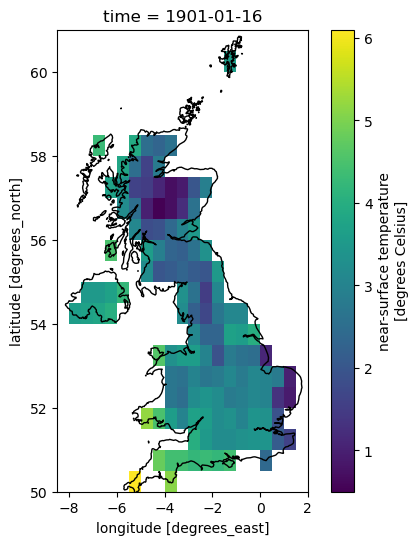

In [75]:
# Plotting time = 0 with UK boundaries
from shapely.geometry import Point

# Take one time slice just to build the spatial grid
da0 = df_uk["tmp"].isel(time=0)

# Build lon/lat mesh
lon2d, lat2d = np.meshgrid(df_uk["lon"].values, df_uk["lat"].values)

# Make points GeoDataFrame
pts = gpd.GeoDataFrame(
    geometry=gpd.points_from_xy(lon2d.ravel(), lat2d.ravel()),
    crs="EPSG:4326"
)

# Keep only points inside the UK polygon
inside = pts.within(uk.geometry.iloc[0]).values.reshape(lat2d.shape)

# Mask: set outside polygon to NaN
da0_masked = da0.where(inside)

fig, ax = plt.subplots(figsize=(6,6))

da0_masked.plot(ax=ax)                 # xarray draws on this Axes
uk.boundary.plot(ax=ax, color="black", linewidth=1)

plt.show()
